## Fine-tune SegFormer on a custom dataset

In this notebook, we are going to fine-tune [SegFormerForSemanticSegmentation](https://huggingface.co/docs/transformers/main/model_doc/segformer#transformers.SegformerForSemanticSegmentation) on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [37]:
!pip install -q transformers datasets evaluate

## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [38]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Note that this dataset is now also available on the hub :) you can directly check out the images [in your browser](scene_parse_150)! It can be easily loaded as follows (note that loading will take some time as the dataset is several GB's large):

In [39]:
from datasets import load_dataset

load_entire_dataset = False

if load_entire_dataset:
  dataset = load_dataset("scene_parse_150")

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [40]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the image processor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [41]:
from transformers import SegformerImageProcessor

root_dir = './ADE20k_toy_dataset'
image_processor = SegformerImageProcessor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

/Users/odai/cs5567-final-project/.venv/lib/python3.11/site-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [42]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [43]:
encoded_inputs = train_dataset[0]

In [44]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [45]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [46]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [47]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Next, we define corresponding dataloaders.

In [48]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [49]:
batch = next(iter(train_dataloader))

In [50]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [51]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [52]:
mask = (batch["labels"] != 255)
mask

tensor([[[False,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [False, False,  True,  ...,  True, False, False],
         [False, False,  True,  ...,  True, False, False],
         [False, False, False,  ..., False, False, False]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]]])

In [53]:
batch["labels"][mask]

tensor([ 0,  0,  0,  ..., 13, 13, 13])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [54]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

/Users/odai/cs5567-final-project/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 

## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [55]:
import evaluate

metric = evaluate.load("mean_iou")

In [56]:
image_processor.do_reduce_labels

True

In [57]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/odai/cs5567-final-project/.venv/lib/python3.11/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/Users/odai/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/odai/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 5.070526599884033
Mean_iou: 0.00023158697947700413
Mean accuracy: 0.0022709230670892168
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.932852268218994
Mean_iou: 0.0012588863315303224
Mean accuracy: 0.011472375250533202
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.788744926452637
Mean_iou: 0.00516900586775888
Mean accuracy: 0.03918148158527726
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.6358819007873535
Mean_iou: 0.011404235809706153
Mean accuracy: 0.0630097473460515
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.543120861053467
Mean_iou: 0.02428878859544989
Mean accuracy: 0.14605853054749857
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.334003448486328
Mean_iou: 0.03793962343518093
Mean accuracy: 0.2810947064452102
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.216538429260254
Mean_iou: 0.03716599833291655
Mean accuracy: 0.3203442354798996
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.114036560058594
Mean_iou: 0.03588904701023708
Mean accuracy: 0.22204256641208128
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.61242938041687
Mean_iou: 0.15460604888635288
Mean accuracy: 0.5132087820086153
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.417886257171631
Mean_iou: 0.19384355751540996
Mean accuracy: 0.6003193231325934
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.377990961074829
Mean_iou: 0.05037124878352375
Mean accuracy: 0.14926707812225126
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.939776659011841
Mean_iou: 0.26198932388352697
Mean accuracy: 0.42877458960514647
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.624174118041992
Mean_iou: 0.2007354408025038
Mean accuracy: 0.3629145598156697
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.602907180786133
Mean_iou: 0.1474504982241172
Mean accuracy: 0.26046002747868857
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.4428224563598633
Mean_iou: 0.1757861542246797
Mean accuracy: 0.43660041818693124
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.0555403232574463
Mean_iou: 0.17865025263661732
Mean accuracy: 0.32747108741752085
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.999554395675659
Mean_iou: 0.15567450680592704
Mean accuracy: 0.3196619293631471
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8925042152404785
Mean_iou: 0.3289591419283502
Mean accuracy: 0.6059540013086953
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.707186698913574
Mean_iou: 0.16729596349678788
Mean accuracy: 0.27144690999166887
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.7845659255981445
Mean_iou: 0.3142222017679555
Mean accuracy: 0.4535188751991739
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.0673444271087646
Mean_iou: 0.24138426055910125
Mean accuracy: 0.33738883866578234
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.633435010910034
Mean_iou: 0.3985918266971
Mean accuracy: 0.6867634025732252
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.72021746635437
Mean_iou: 0.3607302919359617
Mean accuracy: 0.5305489810124775
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.272322177886963
Mean_iou: 0.15072736906953524
Mean accuracy: 0.3419354343524036
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.534559726715088
Mean_iou: 0.41914947939536074
Mean accuracy: 0.6675580601349295
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.7475991249084473
Mean_iou: 0.33891079942669095
Mean accuracy: 0.5216206476485579
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.398228406906128
Mean_iou: 0.1085067173218568
Mean accuracy: 0.18973942398070867
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.565605401992798
Mean_iou: 0.21687403581428008
Mean accuracy: 0.3219064317516253
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0922510623931885
Mean_iou: 0.14640978511809127
Mean accuracy: 0.2709291944163335
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.3862898349761963
Mean_iou: 0.29471096630192894
Mean accuracy: 0.40998332035149027
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1406307220458984
Mean_iou: 0.10933609252241874
Mean accuracy: 0.1929459282365953
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1869661808013916
Mean_iou: 0.3071807192834877
Mean accuracy: 0.48378923541681745
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8423538208007812
Mean_iou: 0.2495858060296091
Mean accuracy: 0.39778771202935687
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.2517223358154297
Mean_iou: 0.3750070406444069
Mean accuracy: 0.5060801576358355
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.702980875968933
Mean_iou: 0.2653189316611457
Mean accuracy: 0.4191638929724412
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3435479402542114
Mean_iou: 0.23717856955552807
Mean accuracy: 0.2776914151325078
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1439082622528076
Mean_iou: 0.20380668713599248
Mean accuracy: 0.2881015977417915
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.28657865524292
Mean_iou: 0.5074417929654743
Mean accuracy: 0.7543844419622996
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.223517656326294
Mean_iou: 0.3297640441670901
Mean accuracy: 0.5172512989937114
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6827186346054077
Mean_iou: 0.6645213700359295
Mean accuracy: 0.7293381463455173
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.887441635131836
Mean_iou: 0.1869582412380746
Mean accuracy: 0.317575056617459
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4663084745407104
Mean_iou: 0.3741927309321466
Mean accuracy: 0.4938003929864547
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1013233661651611
Mean_iou: 0.6909129636960556
Mean accuracy: 0.8295030818347044
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2598490715026855
Mean_iou: 0.39665026298668254
Mean accuracy: 0.5222863878903117
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.49326491355896
Mean_iou: 0.15383183003000914
Mean accuracy: 0.2839327299452011
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7323405742645264
Mean_iou: 0.47269827730733244
Mean accuracy: 0.5689146096758485
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5008280277252197
Mean_iou: 0.32384645570319226
Mean accuracy: 0.5609903444987473
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8803781270980835
Mean_iou: 0.36395058614939146
Mean accuracy: 0.5085893221526272
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7543326616287231
Mean_iou: 0.22703477183490187
Mean accuracy: 0.30539642589058824
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3453375101089478
Mean_iou: 0.6568583611216964
Mean accuracy: 0.7867339435581017


## Inference

Finally, let's check whether the model has really learned something.

Let's test the trained model on an image (refer to my [inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb) for details):

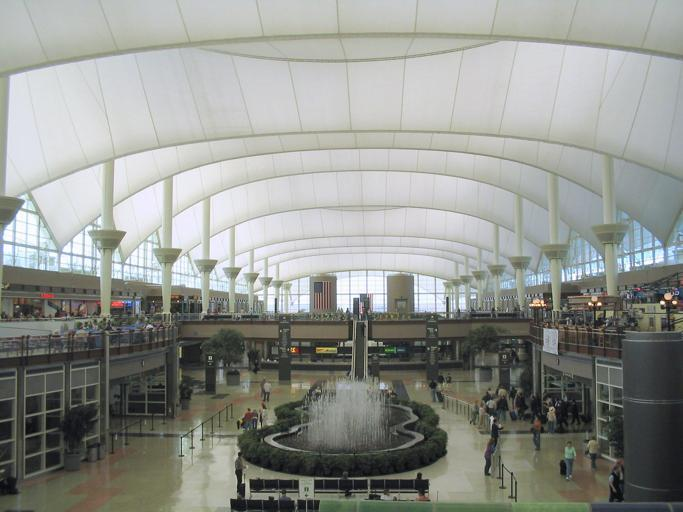

In [58]:
image = Image.open('./ADE20k_toy_dataset/images/training/ADE_train_00000001.jpg')
image

In [59]:
# prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [60]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [61]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [62]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [63]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 ...
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]]


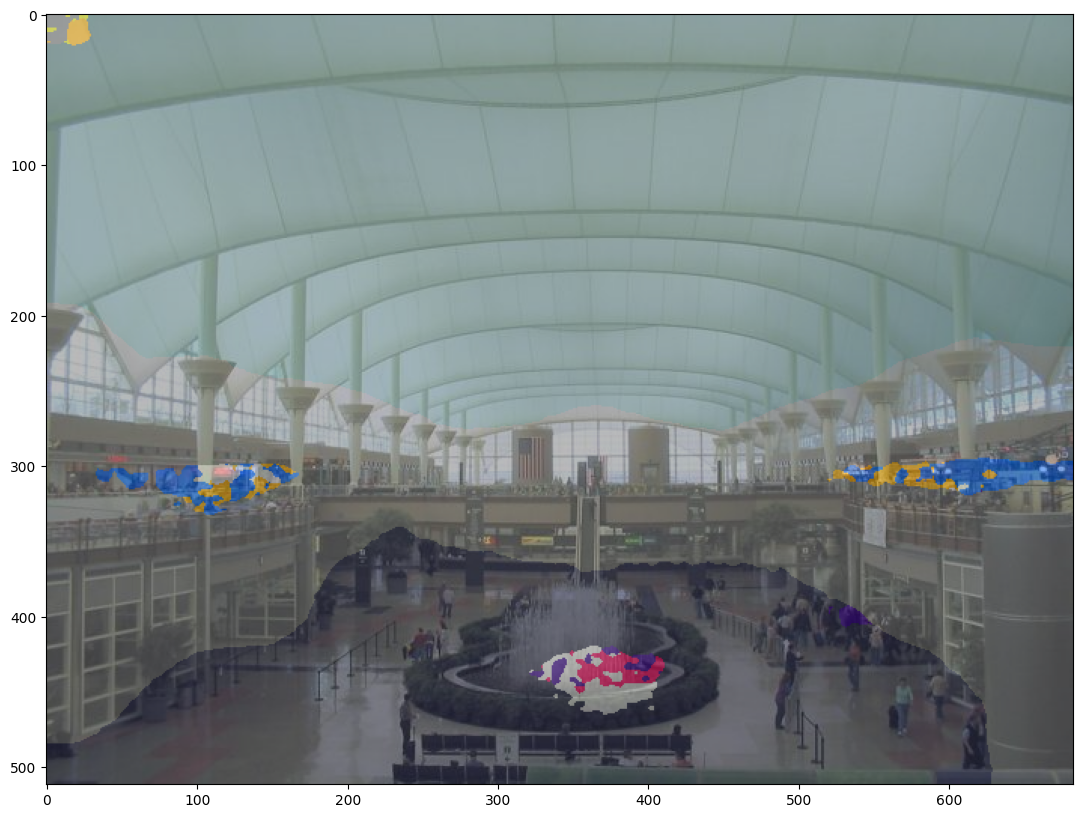

In [64]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth segmentation map:

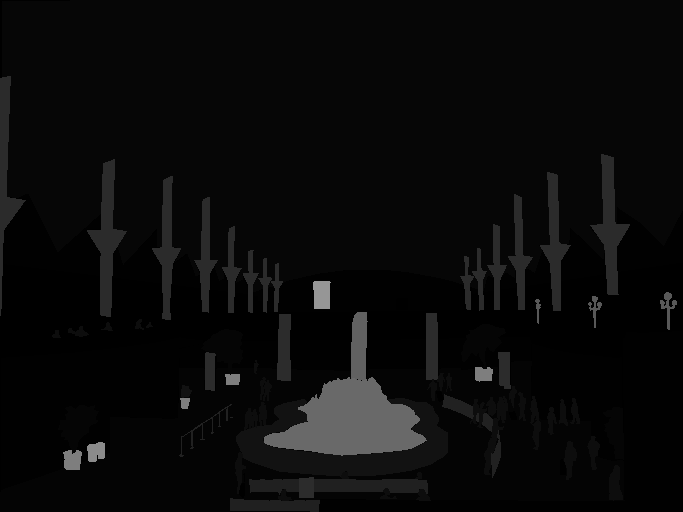

In [65]:
map = Image.open('./ADE20k_toy_dataset/annotations/training/ADE_train_00000001.png')
map

Classes in this image: ['wall', 'floor', 'tree', 'ceiling', 'person', 'plant', 'seat', 'fence', 'column', 'signboard', 'streetlight', 'escalator', 'fountain', 'pot', 'ashcan', 'flag', None]


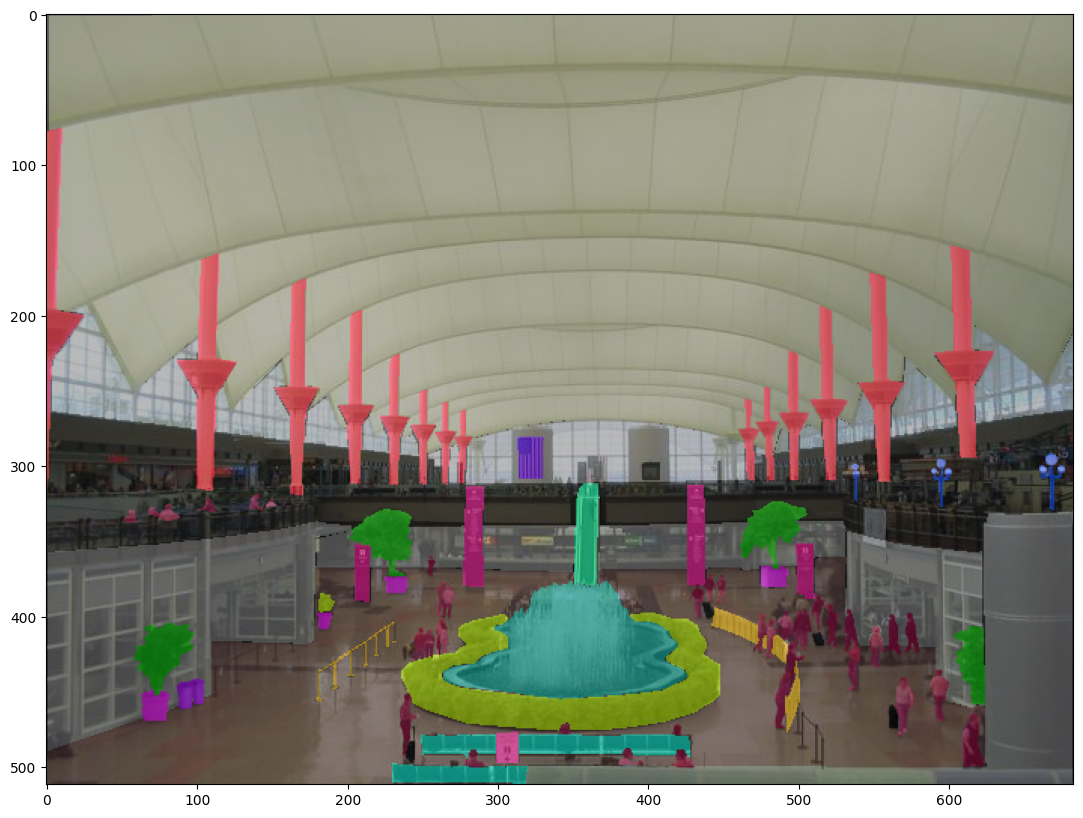

In [66]:
# convert map to NumPy array
import cv2
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = cv2.resize(color_seg, (img.shape[1], img.shape[0]))

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Let's compute the metrics:

In [67]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric._compute(
                  predictions=[predicted_segmentation_map],
                  references=[map],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

In [68]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [69]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.09842423044292366
mean_accuracy 0.17739699909377724
overall_accuracy 0.8084683238758013
---------------------
per-category metrics:


,IoU,accuracy
wall,0.657012,0.880763
building,NaN,NaN
sky,0.000000,NaN
floor,0.562856,0.978105
tree,0.000000,0.000000
...,...,...
shower,NaN,NaN
radiator,NaN,NaN
glass,NaN,NaN
clock,NaN,NaN


In [70]:
metric_table

{'wall': [0.6570124178232286, 0.880763142003819],
 'building': [nan, nan],
 'sky': [0.0, nan],
 'floor': [0.5628562559963881, 0.9781052321875153],
 'tree': [0.0, 0.0],
 'ceiling': [0.9346440142603324, 0.9673154697161812],
 'road': [nan, nan],
 'bed ': [nan, nan],
 'windowpane': [0.0, nan],
 'grass': [nan, nan],
 'cabinet': [nan, nan],
 'sidewalk': [nan, nan],
 'person': [0.010820381664371435, 0.012168141592920354],
 'earth': [nan, nan],
 'door': [nan, nan],
 'table': [nan, nan],
 'mountain': [nan, nan],
 'plant': [0.0, 0.0],
 'curtain': [nan, nan],
 'chair': [nan, nan],
 'car': [nan, nan],
 'water': [nan, nan],
 'painting': [nan, nan],
 'sofa': [nan, nan],
 'shelf': [nan, nan],
 'house': [nan, nan],
 'sea': [nan, nan],
 'mirror': [0.0, nan],
 'rug': [nan, nan],
 'field': [nan, nan],
 'armchair': [nan, nan],
 'seat': [0.0, 0.0],
 'fence': [0.0, 0.0],
 'desk': [nan, nan],
 'rock': [nan, nan],
 'wardrobe': [nan, nan],
 'lamp': [nan, nan],
 'bathtub': [0.0, nan],
 'railing': [nan, nan],
 '

## Spot checking other images

In [71]:
val_imgs = [
    './ADE20k_toy_dataset/images/training/ADE_train_00000002.jpg',
    './ADE20k_toy_dataset/images/training/ADE_train_00000005.jpg',
    './ADE20k_toy_dataset/images/training/ADE_train_00000007.jpg',
]

In [72]:
for k,v in enumerate(val_imgs):
    image = Image.open(v)
    
    # prepare the image for the model
    pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
    
    # forward pass
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        
    # logits are of shape (batch_size, num_labels, height/4, width/4)
    logits = outputs.logits.cpu()
    
    predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()

    # create coloured map
    color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
    palette = np.array(ade_palette())
    for label, color in enumerate(palette):
        color_seg[map == label, :] = color
    # Convert to BGR
    color_seg = cv2.resize(color_seg, (img.shape[1], img.shape[0]))

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.show()
    
    # # metric expects a list of numpy arrays for both predictions and references
    # metrics = metric._compute(
    #                 predictions=[predicted_segmentation_map],
    #                 references=[map],
    #                 num_labels=len(id2label),
    #                 ignore_index=255,
    #                 reduce_labels=False, # we've already reduced the labels ourselves
    #             )
    
    # # print overall metrics
    # for key in list(metrics.keys())[:3]:
    #     print(key, metrics[key])

ValueError: operands could not be broadcast together with shapes (512,711,3) (512,683,3) 